(supervised:text-classification:training)=
# Training

In this second chapter on text classification we train several machine learning models on the preprocessed data from the first chapter.

## Loading Data

In [1]:
import pandas as pd
import numpy as np

data_path = '/data/datasets/blogs/'

In [2]:
blogs = pd.read_csv(data_path + 'blogs.csv', index_col=0)

blogs

gender  age            industry
1000331      f   37             unknown
1000866      f   17             Student
1004904      m   23                Arts
1005076      f   25                Arts
1005545      m   25         Engineering
...        ...  ...                 ...
996147       f   36  Telecommunications
997488       m   25             unknown
998237       f   16             unknown
998966       m   27             unknown
999503       m   25            Internet

[19320 rows x 3 columns]

In [3]:
posts = pd.read_csv(data_path + 'posts.csv', index_col=0)
posts_lemmatized = pd.read_csv(data_path + 'posts_lemmatized.csv', index_col=0)

posts['lemmatized'] = posts_lemmatized['lemmatized']

posts

blog_id  day  month  year  \
0       1000331   31      5  2004   
1       1000331   29      5  2004   
2       1000331   28      5  2004   
3       1000331   28      5  2004   
4       1000331   28      5  2004   
...         ...  ...    ...   ...   
676023   999503    4      7  2004   
676024   999503    3      7  2004   
676025   999503    2      7  2004   
676026   999503    1      7  2004   
676027   999503    1      7  2004   

                                                     text  \
0       Well, everyone got up and going this morning. ...   
1       My four-year old never stops talking.  She'll ...   
2       Actually it's not raining yet, but I bought 15...   
3       Ha! Just set up my RSS feed - that is so easy!...   
4       Oh, which just reminded me, we were talking ab...   
...                                                   ...   
676023  Today we celebrate our independence day.    In...   
676024  Ugh, I think I have allergies...  My nose has ...   
676025  "Science is like sex; occasionally something p...   
676026  Dog toy or marital aid   I managed 10/14 on th...   
676027  I had a dream last night about a fight when I ...   

                                               lemmatized  
0       well get up go morning still raining okay sort...  
1       old never stop talk say mom say say oh yeah do...  
2       actually not raining yet buy ticket game mom b...  
3       ha just set r feed be so easy do do enough tod...  
4       just remind be talk can food coffee break morn...  
...                                                   ...  
676023  today celebrate independence day honor event g...  
676024  think have allergy nose have be stuff week mak...  
676025  science be sex occasionally practical come not...  
676026  dog toy marital aid manage little quiz see wel...  
676027  have dream last night fight be younger dad hea...  

[653702 rows x 6 columns]

Some posts do not contain any lemmatized text. Note that Pandas interprets empty fields in a CSV file as `nan`. So we may run into troubles if we do not replace `nan` by empty strings or remove the rows from the data frame.

In [4]:
posts.loc[posts['lemmatized'].isna(), :]

blog_id  day  month  year  \
830     1004904   19      6  2004   
1166    1008329   10      4  2004   
1756    1011311   25      5  2004   
3882    1022086    6      7  2004   
3885    1022086    6      7  2004   
...         ...  ...    ...   ...   
673231   988941    3      2  2003   
674144   988941   19      1  2004   
674253   988941   25      3  2004   
674723   992078   17     11  2003   
675851   998237   28      8  2003   

                                                     text lemmatized  
830                                              J.A.M.C.        NaN  
1166               www.teenopendiary.com ----> elysicidal        NaN  
1756                                         artie and me        NaN  
3882                                      The three of us        NaN  
3885                                         Amalia and I        NaN  
...                                                   ...        ...  
673231                                    I will, I will!        NaN  
674144                                              What?        NaN  
674253                                           YAYness!        NaN  
674723  Ugh.     http://www.cnn.com/2003/US/Southwest/...        NaN  
675851                 whoa im tlaking to kevin daly whoa        NaN  

[968 rows x 6 columns]

In [5]:
posts.dropna(how='any', inplace=True)

posts

blog_id  day  month  year  \
0       1000331   31      5  2004   
1       1000331   29      5  2004   
2       1000331   28      5  2004   
3       1000331   28      5  2004   
4       1000331   28      5  2004   
...         ...  ...    ...   ...   
676023   999503    4      7  2004   
676024   999503    3      7  2004   
676025   999503    2      7  2004   
676026   999503    1      7  2004   
676027   999503    1      7  2004   

                                                     text  \
0       Well, everyone got up and going this morning. ...   
1       My four-year old never stops talking.  She'll ...   
2       Actually it's not raining yet, but I bought 15...   
3       Ha! Just set up my RSS feed - that is so easy!...   
4       Oh, which just reminded me, we were talking ab...   
...                                                   ...   
676023  Today we celebrate our independence day.    In...   
676024  Ugh, I think I have allergies...  My nose has ...   
676025  "Science is like sex; occasionally something p...   
676026  Dog toy or marital aid   I managed 10/14 on th...   
676027  I had a dream last night about a fight when I ...   

                                               lemmatized  
0       well get up go morning still raining okay sort...  
1       old never stop talk say mom say say oh yeah do...  
2       actually not raining yet buy ticket game mom b...  
3       ha just set r feed be so easy do do enough tod...  
4       just remind be talk can food coffee break morn...  
...                                                   ...  
676023  today celebrate independence day honor event g...  
676024  think have allergy nose have be stuff week mak...  
676025  science be sex occasionally practical come not...  
676026  dog toy marital aid manage little quiz see wel...  
676027  have dream last night fight be younger dad hea...  

[652734 rows x 6 columns]

## Counting Words

As discussed in the previous chapter we use the *bag of words* model: features are word counts and feature space dimension equals the size of the dictionary. Say we have $m$ different words in our dictionary. Then the components $x^{(1)},\ldots,x^{(m)}$ of a feature vector $x$ count the occurrences of words $1,\ldots,m$ of the dictionary in a blog post.

The dictionary is created from the training data. Important: words not contained in the training data will be ignored by the model. So training data has to be sufficiently rich. To generate the dictionary we have to split data into training and test sets. But up to now we did not compose concrete training samples.

### Model Inputs and Outputs

Model inputs will be vectors of word counts (or of numbers derived from word counts, see below). For the moment we only have strings. We arrange all the strings in a 1d NumPy array:

In [6]:
S = posts['lemmatized'].to_numpy()

print(S.shape)
S

(652734,)


array(['well get up go morning still raining okay sort suit mood easily have stay home bed book cat have be lot rain people have wet basement be lake be golf course fields be green green green be suppose be degree friday be deal mosquito next week hear winnipeg describe old testament city cbc radio one last week sort rings true flood infestation',
       'old never stop talk say mom say say oh yeah do lady bug hide rain hear own voice very very exhaust now remember be go work sigh',
       'actually not raining yet buy ticket game mom birthday tonight be suppose rain do cancel baseball game rain ballpark be beautiful ai use go jay game live toronto really take kid game now do know blue jay ticket cost now sure cheap here winnipeg oh just check definitely be',
       ..., 'science be sex occasionally practical come not reason do',
       'dog toy marital aid manage little quiz see well do',
       'have dream last night fight be younger dad heavy wrench brother hit head be bleed bad hop

Model outputs will be class labels. We have 6 classes: all combinations of 2 genders and 3 age groups.

In [7]:
# add one column per class
posts['label'] = ''

# fill columns blogwise
for blog_id in blogs.index:
    
    # get class for blog
    label = blogs.loc[blog_id, 'gender']
    if blogs.loc[blog_id, 'age'] < 20:
        label = label + '1'
    elif blogs.loc[blog_id, 'age'] < 30:
        label = label + '2'
    else:
        label = label + '3'
        
    # set class for all posts of the blog
    posts.loc[posts['blog_id'] == blog_id, 'label'] = label
    
posts

blog_id  day  month  year  \
0       1000331   31      5  2004   
1       1000331   29      5  2004   
2       1000331   28      5  2004   
3       1000331   28      5  2004   
4       1000331   28      5  2004   
...         ...  ...    ...   ...   
676023   999503    4      7  2004   
676024   999503    3      7  2004   
676025   999503    2      7  2004   
676026   999503    1      7  2004   
676027   999503    1      7  2004   

                                                     text  \
0       Well, everyone got up and going this morning. ...   
1       My four-year old never stops talking.  She'll ...   
2       Actually it's not raining yet, but I bought 15...   
3       Ha! Just set up my RSS feed - that is so easy!...   
4       Oh, which just reminded me, we were talking ab...   
...                                                   ...   
676023  Today we celebrate our independence day.    In...   
676024  Ugh, I think I have allergies...  My nose has ...   
676025  "Science is like sex; occasionally something p...   
676026  Dog toy or marital aid   I managed 10/14 on th...   
676027  I had a dream last night about a fight when I ...   

                                               lemmatized label  
0       well get up go morning still raining okay sort...    f3  
1       old never stop talk say mom say say oh yeah do...    f3  
2       actually not raining yet buy ticket game mom b...    f3  
3       ha just set r feed be so easy do do enough tod...    f3  
4       just remind be talk can food coffee break morn...    f3  
...                                                   ...   ...  
676023  today celebrate independence day honor event g...    m2  
676024  think have allergy nose have be stuff week mak...    m2  
676025  science be sex occasionally practical come not...    m2  
676026  dog toy marital aid manage little quiz see wel...    m2  
676027  have dream last night fight be younger dad hea...    m2  

[652734 rows x 7 columns]

In [8]:
posts['label'] = posts['label'].astype('category')
posts['label'] = posts['label'].cat.reorder_categories(['f1', 'f2', 'f3', 'm1', 'm2', 'm3'])
print(posts['label'].cat.categories)

Index(['f1', 'f2', 'f3', 'm1', 'm2', 'm3'], dtype='object')


In [9]:
y = posts['label'].cat.codes.to_numpy()

y.shape

(652734,)

### Train-Test Split

In [10]:
posts.loc[posts['lemmatized'].isna(), :]

Empty DataFrame
Columns: [blog_id, day, month, year, text, lemmatized, label]
Index: []

In [11]:
import sklearn.model_selection as model_selection

In [12]:
S_train, S_test, y_train, y_test = model_selection.train_test_split(S, y, test_size=0.2)

S_train.shape, S_test.shape

((522187,), (130547,))

### Simple Word Counting

Scikit-Learn implements dictionary generation and word counting in [`sklearn.feature_extraction.text.CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). All strings by default are converted to lower case. Scikit-Learn's `CountVectorizer` counts occurrences of words or group of words (*n-grams*). Counting words is the default. Stop words can be removed automatically based on a built-in list of English stop words.

Calling `fit` builds the dictionary. Calling `transform` counts words based on the dictionary. As usual `fit_transform` does both steps at once. But for `CountVectorizer` calling `fit_transform` is more efficient than calling `fit` and `transform` separately.

`CountVectorizer` provides some options for excluding rare or very frequent words. We will come back to those options below.

In [13]:
import sklearn.feature_extraction.text as fe_text

In [14]:
count_vect = fe_text.CountVectorizer()
X_train = count_vect.fit_transform(S_train)

In [15]:
X_train.shape

(522187, 50985)

We have more than 50000 different words in our vocabulary. The vocabulary is accessible through `Count_vect.vocabulary_`. It's a dict with strings as keys and corresponding indices as values.

In [16]:
count_vect.vocabulary_['sunshine']

43601

The feature with this index contains counts of 'sunshine'.

We should have a closer look on the word counts. There will be some words occurring only in very few post. From such rare words a machine learning model cannot learn something useful. On the other hand, words appearing in almost all posts do not contain information to differentiate between classes.

The number of samples containing a fixed word is denoted as *document frequency (DF)* of the word. The word count within one sample is denoted as *term frequency (TF)* of the word (and the sample).

Let's have a look at document frequencies:

In [17]:
dfs = np.array(X_train.sign().sum(axis=0)).reshape(-1)
words = count_vect.vocabulary_.keys()
idxs = count_vect.vocabulary_.values()

vocabulary = pd.DataFrame({'word': words, 'idx': idxs})
vocabulary['df'] = dfs[vocabulary['idx'].to_numpy()]

vocabulary = vocabulary.sort_values('df', ascending=False)

vocabulary

word    idx      df
5                 be   4005  439217
81              have  20248  332156
11                do  13220  297286
125              get  18599  244616
1                 go  18935  241553
...              ...    ...     ...
50948         taipeh  44256       1
50949      razorbill  36475       1
50950       porifera  34339       1
50951     reformable  36939       1
50952  periodontitis  33028       1

[50985 rows x 3 columns]

Note that `X_train` is not a usual NumPy array, but a sparse array. The `sum` method works as usual, but reshaping is not supported by sparse arrays. Thus, we convert the result of `sum` (which is much smaller than `X_train`) into a NumPy array before reshaping it.

Here is a list of words occuring only in very few posts:

In [18]:
vocabulary.loc[vocabulary['df'] < 5,'word']

39234          dashiki
39075          peerage
39076       pictograph
39079         diamante
39288               3d
             ...      
50948           taipeh
50949        razorbill
50950         porifera
50951       reformable
50952    periodontitis
Name: word, Length: 13572, dtype: object

More than 13000 words appear in only 1 to 4 posts. Such rare words should be removed from the vocabulary. In other words, we may remove more than 13000 features, because they do not contain useful information.

Here are the words appearing most often together with the cut of posts containing them:

In [19]:
for idx in range(100):
    word = vocabulary['word'].iloc[idx]
    df = vocabulary['df'].iloc[idx]
    print(word, '({:.2f})'.format(df / X_train.shape[0]), end=' ')

be (0.84) have (0.64) do (0.57) get (0.47) go (0.46) not (0.44) so (0.43) just (0.40) think (0.34) know (0.33) now (0.32) make (0.31) time (0.30) say (0.30) more (0.27) see (0.27) really (0.27) well (0.26) good (0.26) come (0.25) then (0.25) take (0.25) want (0.25) day (0.22) people (0.22) much (0.22) back (0.22) work (0.21) today (0.21) here (0.21) only (0.21) look (0.21) even (0.20) too (0.19) other (0.19) last (0.19) way (0.19) still (0.18) right (0.18) need (0.17) new (0.17) love (0.17) tell (0.17) feel (0.17) things (0.17) try (0.17) first (0.17) very (0.16) life (0.16) start (0.16) give (0.16) thing (0.16) there (0.16) little (0.16) also (0.15) night (0.15) again (0.15) friend (0.15) call (0.15) never (0.14) talk (0.14) leave (0.14) home (0.13) use (0.13) most (0.13) long (0.13) week (0.13) let (0.13) mean (0.13) like (0.12) keep (0.12) as (0.12) read (0.12) end (0.12) better (0.12) find (0.12) great (0.12) guy (0.11) ever (0.11) always (0.11) next (0.11) few (0.11) write (0.11) 

Here we see that there are no words that appear in almost all posts. In principle, every word might be useful to differentiate between classes. Even if we would throw away words appearing in, for instance, more than 50 per cent of posts, we could remove only 3 features.

Scikit-Learn's `CountVectorizer()` takes parameters `min_df` and `max_df` to exclude rare words and words appearing very often, respectively.

In [20]:
count_vect = fe_text.CountVectorizer(min_df=5, max_df=1.0)
X_train = count_vect.fit_transform(S_train)

X_train.shape

(522187, 37413)

### Weighted Counting

For short posts word counts will be lower than for longer posts. Thus, we should normalize word counts. Then feature values contain counts relative to the length of a post. Here we use [`sklearn.preprocessing.normalize`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html).

In [21]:
import sklearn.preprocessing as preprocessing

In [22]:
X_train = preprocessing.normalize(X_train, norm='l1')

Another issue is the importance of words. The more posts contain a word, the less important for classifying posts the word is. So we could apply a weighting with weights the higher the lower the document frequency is. There exist different concrete weighting rules. The default one of Scikit-Learn is
\begin{equation*}
\text{weight of word}=1+\log\frac{1+\text{number of documents}}{1+\text{document frequency of word}}.
\end{equation*}
If a word appears in all documents, the weight is 1. Else the weight is greater than 1. Sometimes the logarithm is used without adding 1. Then words appearing in all documents have weight 0, that is, they are ignored.

The vector of weighted counts usually is normalized as above.

Scikit-Learn implements this so called TF-IDF-weighting (TF: term frequency, IDF: inverse document frequency) in [`sklearn.feature_extraction.text.TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Usage is identical to `CountVectorizer`.

In [23]:
tfidf_vect = fe_text.TfidfVectorizer(min_df=5, max_df=1.0)
X_train = tfidf_vect.fit_transform(S_train)

X_train.shape

(522187, 37413)

Do not forget to transform test samples in the same way (no second call to `fit`!):

In [24]:
X_test = tfidf_vect.transform(S_test)

X_test.shape

(130547, 37413)

## Naive Bayes Classifier

Feature vectors containing word counts follow a multinomial distribution, which is well suited for naive Bayes classification. Naive Bayes classifiers are very fast in training and prediction because only some emperical probabilities have to be calculated from sample counts. Thus, naive Bayes classifiers can cope with high dimensional feature spaces and large training data sets.

Strictly speaking, naive Bayes classifiers expect integer inputs (counts). But formulas allow for real-valued features, too. There is no theory backing multinomial naive Bayes for real-valued features. But experience shows that it works quite well. In context of bag of words language processing multinomial naive Bayes with TF-IDF values works much better than with simple word counts.

In [25]:
import sklearn.naive_bayes as naive_bayes

In [26]:
mnb = naive_bayes.MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

Note that `MultinomialNB` has only very few parameters with default values suitable for our learning task. By default it uses Laplace smoothing and label probabilities are estimated from the training data (instead of uniform label distribution).

In [27]:
y_train_pred = mnb.predict(X_train)
y_test_pred = mnb.predict(X_test)

For visualizing classification accuracy we use the following function.

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

In [29]:
def show_accuracy(y, y_pred):

    print('correct classification rate:          {:.4f} (random guessing: 0.1667)'.format(metrics.accuracy_score(y, y_pred)))
    print('correct classification rate (gender): {:.4f} (random guessing: 0.5000)'.format(metrics.accuracy_score(y // 3, y_pred // 3)))
    print('correct classification rate (age):    {:.4f} (random guessing: 0.3333)'.format(metrics.accuracy_score(y - 3 * (y // 3), y_pred - 3 * (y_pred // 3))))
    
    # calculate confusion matrices
    cm = pd.crosstab(pd.Series(y, name='truth'), pd.Series(y_pred, name='prediction'))
    cm = cm.reindex(index=[0, 1, 2, 3, 4, 5], columns=[0, 1, 2, 3, 4, 5], fill_value=0)
    cm_gender = pd.crosstab(pd.Series(y // 3, name='truth'), pd.Series(y_pred // 3, name='prediction'))
    cm_gender = cm_gender.reindex(index=[0, 1], columns=[0, 1], fill_value=0)
    cm_age = pd.crosstab(pd.Series(y - 3 * (y // 3), name='truth'), pd.Series(y_pred - 3 * (y_pred // 3), name='prediction'))
    cm_age = cm_age.reindex(index=[0, 1, 2], columns=[0, 1, 2], fill_value=0)

    # normalize rows of confusion matrices (we have unbalanced classes)
    cm = cm.astype(float)
    cm_gender = cm_gender.astype(float)
    cm_age = cm_age.astype(float)
    for i in range(0, 6):
        cm.loc[i, :] = cm.loc[i, :] / cm.loc[i, :].sum()
    for i in range(0, 2):
        cm_gender.loc[i, :] = cm_gender.loc[i, :] / cm_gender.loc[i, :].sum()
    for i in range(0, 3):
        cm_age.loc[i, :] = cm_age.loc[i, :] / cm_age.loc[i, :].sum()
    
    # plot confusion matrices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3.5), tight_layout=True)
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='hot', ax=ax1,
                xticklabels=posts['label'].cat.categories, yticklabels=posts['label'].cat.categories)
    sns.heatmap(cm_gender, annot=cm_gender, fmt='.2f', cmap='hot', ax=ax2,
                xticklabels=['f', 'm'], yticklabels=['f', 'm'])
    sns.heatmap(cm_age, annot=cm_age, fmt='.2f', cmap='hot', ax=ax3,
                xticklabels=['1', '2', '3'], yticklabels=['1', '2', '3'])
    plt.show()

Prediction accuracy on training data:

correct classification rate:          0.4577 (random guessing: 0.1667)
correct classification rate (gender): 0.6777 (random guessing: 0.5000)
correct classification rate (age):    0.6457 (random guessing: 0.3333)


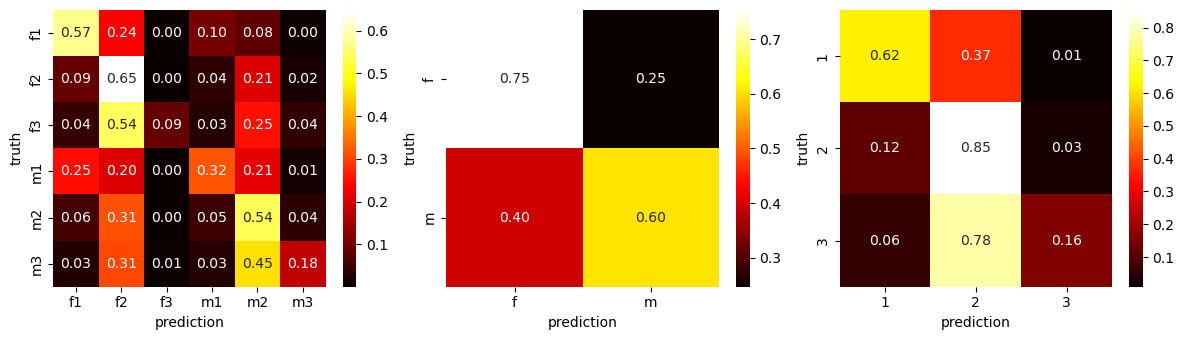

In [30]:
show_accuracy(y_train, y_train_pred)

Prediction accuracy on test data:

In [31]:
show_accuracy(y_test, y_test_pred)

correct classification rate:          0.4338 (random guessing: 0.1667)
correct classification rate (gender): 0.6634 (random guessing: 0.5000)
correct classification rate (age):    0.6351 (random guessing: 0.3333)


Prediction accuracy of the naive Bayes model is much better than random guessing. But we have to take into account class imbalance. Next to random guessing we may consider another trivial model for comparison of prediction accuracy: What happens if a model always predicts the largest class?

In [32]:
samples = np.histogram(y_train, bins=6, range=(-0.5, 5.5))[0]
print(samples)

[ 88173 123839  45420  92169 122165  50421]


In [33]:
show_accuracy(y_test, np.argmax(samples) * np.ones(y_test.shape))

correct classification rate:          0.2402 (random guessing: 0.1667)
correct classification rate (gender): 0.4958 (random guessing: 0.5000)
correct classification rate (age):    0.4727 (random guessing: 0.3333)


Always predicting the largest class works better than random guessing, but not as good as naive Bayes.

We should have a closer look at our model to get a better understanding of it's decision rules and also of the data set. A multinomial Bayes model is completely determined by the probabilities $p_{k,i}$. The values $p_{k,i}$ express the probability to observe feature $k$ (the $k$th word in our vocabulary) in class $i$. The `MultinomialNB` objects provides the logarithm of these probabilities as a 2d NumPy array `MultinomialNB.feature_log_prob_`. First index is the class, second index the feature.

In [34]:
p = np.exp(mnb.feature_log_prob_)

p

array([[2.82486314e-06, 1.06657203e-05, 1.50133781e-05, ...,
        1.94223374e-06, 1.74543529e-06, 2.20958134e-06],
       [2.42658465e-06, 6.50200990e-06, 1.61185337e-05, ...,
        5.40897601e-06, 1.52174765e-06, 1.86291326e-06],
       [3.16922035e-06, 8.23294289e-06, 1.46964824e-05, ...,
        5.55744801e-06, 3.46527245e-06, 2.94293686e-06],
       [4.33136042e-06, 1.01679660e-05, 2.14931631e-05, ...,
        4.23157086e-06, 1.69074347e-06, 2.65137775e-06],
       [2.44322058e-06, 7.15660286e-06, 1.61798918e-05, ...,
        1.32512575e-05, 1.94623715e-06, 2.01389749e-06],
       [3.11215272e-06, 7.82176886e-06, 1.72747277e-05, ...,
        7.67104041e-06, 5.87706081e-06, 3.72104924e-06]])

We may ask: Which words are most likely contained in a post written by a woman in age group 3?

In [35]:
i = 2    # class

# make dict for mapping indices to words
i2w = dict(zip(tfidf_vect.vocabulary_.values(), tfidf_vect.vocabulary_.keys()))

# get 1d array of indices sorted descending by probability
s = p[i, :].argsort()[::-1]

# print most likely words
for idx in s[0:20]:
    print(i2w[idx], p[i, idx])

be 0.01807095671226715
have 0.007949892249550804
do 0.006283225758642027
get 0.004215487511561934
not 0.003949829251723054
go 0.0038146191475615997
so 0.0032094272219337326
just 0.003171984731898014
know 0.0027767618498825836
think 0.002707606061709398
say 0.002463912137631007
make 0.002445372958287036
time 0.00244219262808092
work 0.0023443172188228716
now 0.0022574399274471963
see 0.002239260855123209
day 0.002179888002166481
more 0.0021602842162711912
take 0.002147657978906127
want 0.00208513406619077


Obviously, we have to formulate our question more precisely: Which words are more likely contained in a post written by a woman in age group 3 than in any other class?

In [36]:
i = 2    # class

# get mask for selecting relevant words
likeliest_classes = p.argsort(axis=0)[-1, :]
mask = likeliest_classes == i

# get 1d array of indices sorted descending by probability
s = p[i, :].argsort()[::-1]

# print most likely words
for idx in s[mask[s]][0:20]:
    print(i2w[idx], p[i, idx])

book 0.0010989358770037991
old 0.0010590729846730097
woman 0.0010209207510928407
kid 0.0010198160240573167
child 0.0009682983100168208
comment 0.0009273079531121888
family 0.0008822763541782803
photo 0.0007498600268252408
rick 0.0007213990173024888
send 0.000693886210236962
husband 0.0006279847725706796
mother 0.0005971536115977698
dog 0.000572935663428436
favorite 0.0005620350678289687
light 0.0005582600807629513
water 0.0005342255476616197
visit 0.0005333974878505576
son 0.0005249505300652883
begin 0.0005129303011784495
body 0.0005077890351387825


This contains some more information about important words in a class. But ultimately we want to know which words dichotomize between classes. So we have to go one step further. Instead of looking for the most likely class given a word, we have to find words for which probabilities of the two most likely classes are as far away from each other as possible. We may calculate the ratio of both probabilities. If it is close to 1, then both probabilities are almost identical. If it is much greater than one, then the one probability is much higher than the other.

In [37]:
best_two_classes = p.argsort(axis=0)[:-3:-1, :]

best_probs_0 = p[best_two_classes[0, :], np.arange(p.shape[1])]
best_probs_1 = p[best_two_classes[1, :], np.arange(p.shape[1])]
prob_ratios =  best_probs_0 / best_probs_1

s = prob_ratios.argsort()[::-1]

for idx in s[0:20]:
    print(i2w[idx], prob_ratios[idx], best_two_classes[0, idx], best_two_classes[1, idx])

guam 57.690526155910824 5 2
corsair 47.53816228311916 5 2
uygur 34.368973906082616 5 2
tyke 31.360347041069716 3 2
battalion 28.488640702798268 2 5
improvised 19.254284653553338 2 3
regiment 18.911414974965442 2 3
xinjiang 18.30088754992347 5 2
expeditionary 18.082096818654847 2 5
infantry 15.621887983747696 2 5
pfc 15.156355170252311 2 5
spanner 15.112521737020673 2 1
dayton 14.519504223779798 5 4
40th 14.329376817750704 2 5
venerable 14.172037806976384 2 5
sherry 13.689534679813065 2 0
feast 13.499351300023987 2 1
cavalry 13.273764590605861 2 5
oratory 11.670985186018493 2 3
recessional 11.48808974663984 2 5


This list contains several words related to military, war, politics. Presumable there is a blog in our data set discussing such topics in many posts. Even if there is only one blog containing some word, which has many posts, the word is not removed from the vocabulary because it is contained in many documents. All those posts then have identical labels. Consequently, the word in question is tightly connected with one class. To avoid such one-blog influences we could classify whole blogs, that is, consider all posts of a blog as one document.

Correct classification rates are not as high as they should be. So let's further investigate prediction quality. It seems obvious that longer posts should be easier to classify than short posts, because long post contain more words and, thus, more information about the author.

In [38]:
lengths = np.array([len(s) for s in S_test])
mask = lengths > 1000

print('considering {} posts'.format(mask.sum()))

show_accuracy(y_test[mask], y_test_pred[mask])

considering 23419 posts
correct classification rate:          0.4712 (random guessing: 0.1667)
correct classification rate (gender): 0.7006 (random guessing: 0.5000)
correct classification rate (age):    0.6542 (random guessing: 0.3333)


Considering only posts with at least 1000 characters indeed yields slightly better correct classification rates. Here comes some more detail: sort all posts by length, bin sorted posts into bins of equal size, calculate correct classification rate for each bin.

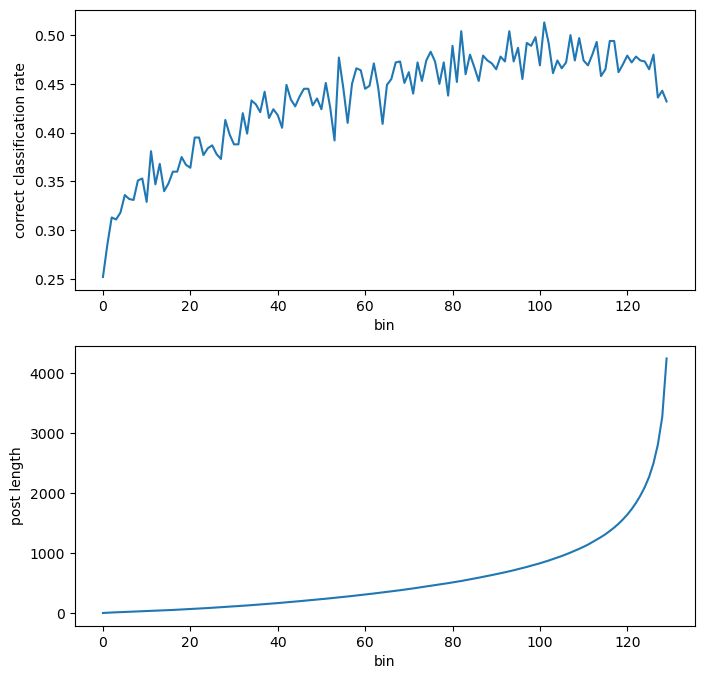

In [39]:
bin_size = 1000

lengths = np.array([len(s) for s in S_test])
s = lengths.argsort()

acc = []
mean_length = []
for k in range(bin_size, s.size, bin_size):
    acc.append(metrics.accuracy_score(y_test[s[(k-bin_size):k]], y_test_pred[s[(k-bin_size):k]]))
    mean_length.append(lengths[s[(k-bin_size):k]].mean())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(acc)
ax2.plot(mean_length)
ax1.set_xlabel('bin')
ax1.set_ylabel('correct classification rate')
ax2.set_xlabel('bin')
ax2.set_ylabel('post length')
plt.show()

## Support Vector Machine

Scikit-Learn provides different implementations of support vector machines for classification:
* [`SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) is the most general one. It supports linear and kernel SVMs, but is relatively slow.
* [`LinearSVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) is a more efficient implementation supporting only linear SVMs.
* [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) uses gradient descent to minimize some loss function, the hinge loss for instance. It supports penalty terms for regularization and, thus, SVMs.

### Linear SVM

We start with `SGDClassifier`. For multi-class problems the one-versus-all approach is used. The 6 linear models can be trained in parallel.

In [40]:
import sklearn.linear_model as linear_model

In [41]:
sgdsvm = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=1,
                                    n_jobs=1, tol=1e-3, max_iter=10)

param_grid = {'alpha': [0.1 ** k for k in range(0, 10)]}
gs = model_selection.GridSearchCV(sgdsvm, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

print(gs.best_params_)

/opt/conda/envs/python3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/python3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/python3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/python3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/pyth

{'alpha': 1.0000000000000004e-06}


/opt/conda/envs/python3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [42]:
sgdsvm = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=1e-6,
                                    verbose=1, n_jobs=-1, tol=1e-3, max_iter=1000)
sgdsvm.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 219.73, NNZs: 33064, Bias: -2.337957, T: 522187, Avg. loss: 0.779561
Total training time: 0.24 seconds.
-- Epoch 2
Norm: 268.65, NNZs: 37108, Bias: -1.501407, T: 522187, Avg. loss: 1.184225
Total training time: 0.26 seconds.
-- Epoch 2
Norm: 199.09, NNZs: 35332, Bias: -2.960665, T: 522187, Avg. loss: 0.466104
Total training time: 0.31 seconds.
-- Epoch 2
Norm: 209.23, NNZs: 35929, Bias: -2.149786, T: 522187, Avg. loss: 0.534687
Total training time: 0.33 seconds.
-- Epoch 2
Norm: 237.08, NNZs: 35350, Bias: -2.486370, T: 522187, Avg. loss: 0.908144
Total training time: 0.32 seconds.
-- Epoch 2
Norm: 262.72, NNZs: 36823, Bias: -1.829896, T: 522187, Avg. loss: 1.211338
Total training time: 0.31 seconds.
-- Epoch 2
Norm: 168.64, NNZs: 34434, Bias: -1.778373, T: 1044374, Avg. loss: 0.419178
Total training time: 0.48 seconds.
-- Epoch 3
Norm: 210.25, NNZs: 37329, Bias: -1.387185, T: 1044374, Avg. loss: 0.635662
Total trai

[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    5.3s remaining:   10.6s


Norm: 148.73, NNZs: 37405, Bias: -1.046856, T: 8354992, Avg. loss: 0.461690
Total training time: 5.44 seconds.
-- Epoch 17
Norm: 121.05, NNZs: 35857, Bias: -1.384460, T: 10443740, Avg. loss: 0.309075
Total training time: 5.50 seconds.
-- Epoch 21
Norm: 140.07, NNZs: 37379, Bias: -1.177948, T: 8354992, Avg. loss: 0.475676
Total training time: 5.54 seconds.
-- Epoch 17
Norm: 117.56, NNZs: 37136, Bias: -1.294708, T: 8354992, Avg. loss: 0.351373
Total training time: 5.56 seconds.
-- Epoch 17
Norm: 120.81, NNZs: 35869, Bias: -1.375922, T: 10965927, Avg. loss: 0.308701
Total training time: 5.77 seconds.
Convergence after 21 epochs took 5.77 seconds
Norm: 147.81, NNZs: 37405, Bias: -1.039440, T: 8877179, Avg. loss: 0.460558
Total training time: 5.79 seconds.
-- Epoch 18
Norm: 139.18, NNZs: 37380, Bias: -1.162537, T: 8877179, Avg. loss: 0.474609
Total training time: 5.89 seconds.
-- Epoch 18
Norm: 116.50, NNZs: 37140, Bias: -1.292449, T: 8877179, Avg. loss: 0.350666
Total training time: 5.91 s

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    8.1s finished


SGDClassifier(alpha=1e-06, n_jobs=-1, verbose=1)

In [43]:
y_train_pred = sgdsvm.predict(X_train)
y_test_pred = sgdsvm.predict(X_test)

correct classification rate:          0.5322 (random guessing: 0.1667)
correct classification rate (gender): 0.7157 (random guessing: 0.5000)
correct classification rate (age):    0.6922 (random guessing: 0.3333)


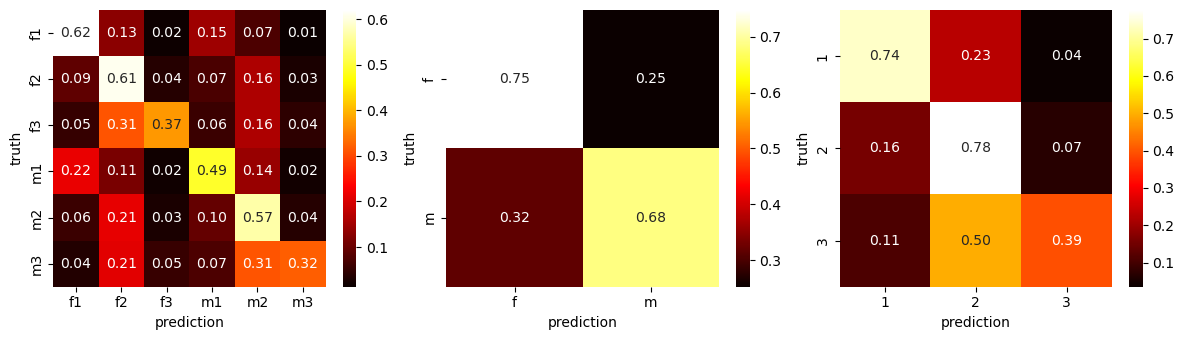

correct classification rate:          0.4530 (random guessing: 0.1667)
correct classification rate (gender): 0.6695 (random guessing: 0.5000)
correct classification rate (age):    0.6397 (random guessing: 0.3333)


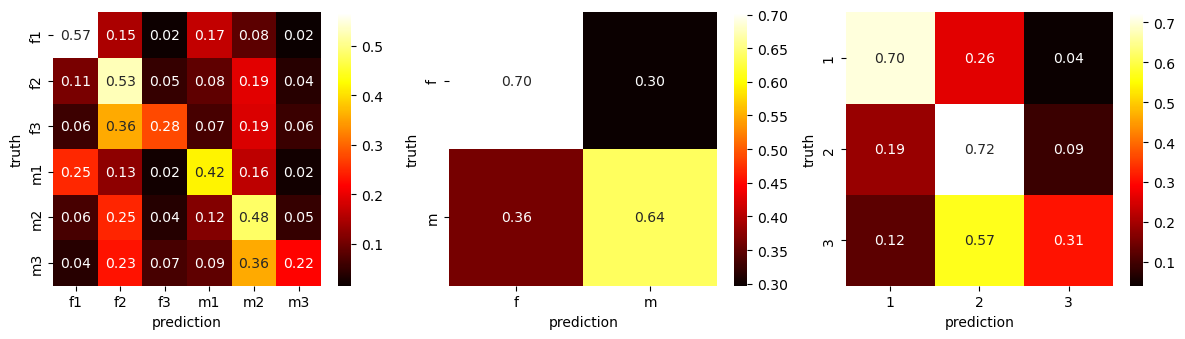

In [44]:
show_accuracy(y_train, y_train_pred)
show_accuracy(y_test, y_test_pred)

Results are slightly better than with naive Bayes. `LinearSVC` should yield similar results because the same optimization problem is solved with a different algorithm.

In [45]:
import sklearn.svm as svm

In [46]:
linearsvm = svm.LinearSVC(C=1e6, tol=1e-3, max_iter=100, dual='auto')
linearsvm.fit(X_train, y_train)

LinearSVC(C=1000000.0, dual='auto', max_iter=100, tol=0.001)

The minimization algorithm shows very slow convergence. Stopping before convergence usually yields low prediction quality.

In [47]:
y_train_pred = linearsvm.predict(X_train)
y_test_pred = linearsvm.predict(X_test)

correct classification rate:          0.5743 (random guessing: 0.1667)
correct classification rate (gender): 0.7393 (random guessing: 0.5000)
correct classification rate (age):    0.7233 (random guessing: 0.3333)


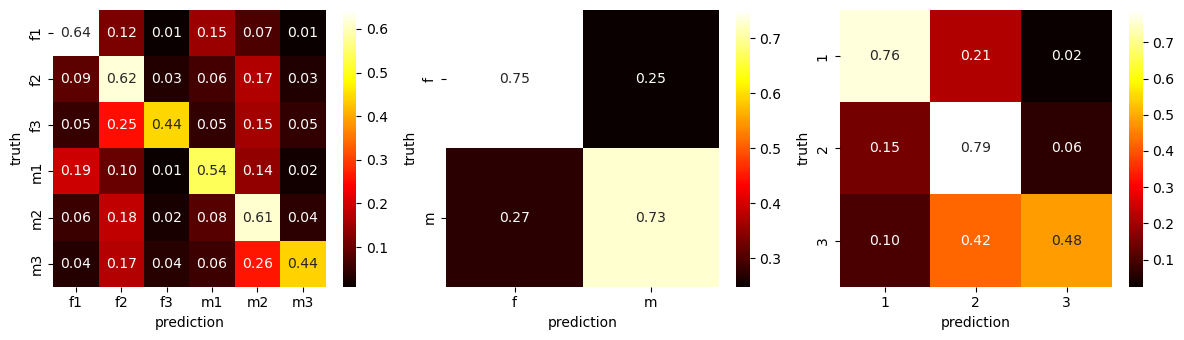

correct classification rate:          0.4520 (random guessing: 0.1667)
correct classification rate (gender): 0.6696 (random guessing: 0.5000)
correct classification rate (age):    0.6392 (random guessing: 0.3333)


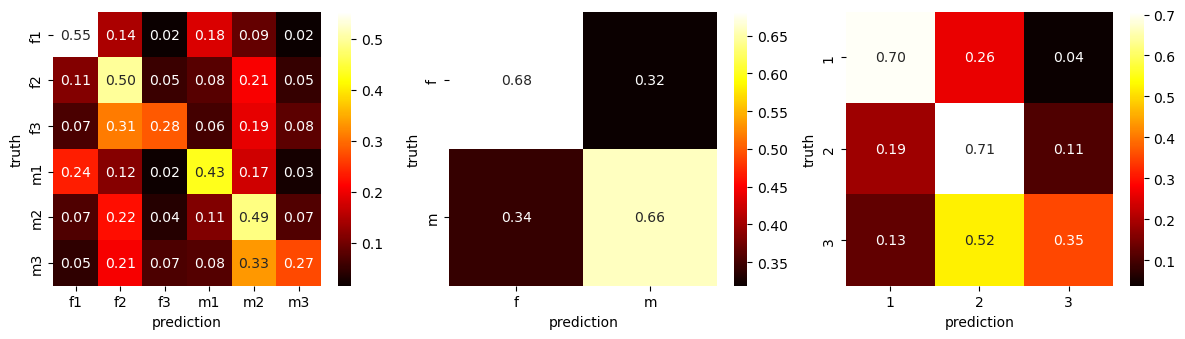

In [48]:
show_accuracy(y_train, y_train_pred)
show_accuracy(y_test, y_test_pred)

### Kernel SVM

To improve prediction quality we could use a nonlinear kernel. This is supported by `SVC`, but requires much more computation time for training as well as for prediction.

Alternatively, we could first transform features and then train a linear classifier. But we have almost 40000 features. Using polynomial features of degree 2 would result in approximately $\frac{40000^2}{2}$, that is, almost 1 billion features.

In [49]:
kernelsvm = svm.SVC(kernel='rbf', C=1e6, tol=1e-5, max_iter=100)
kernelsvm.fit(X_train, y_train)

/opt/conda/envs/python3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(C=1000000.0, max_iter=100, tol=1e-05)

In [50]:
y_train_pred = kernelsvm.predict(X_train)
y_test_pred = kernelsvm.predict(X_test)

correct classification rate:          0.1762 (random guessing: 0.1667)
correct classification rate (gender): 0.4912 (random guessing: 0.5000)
correct classification rate (age):    0.3589 (random guessing: 0.3333)


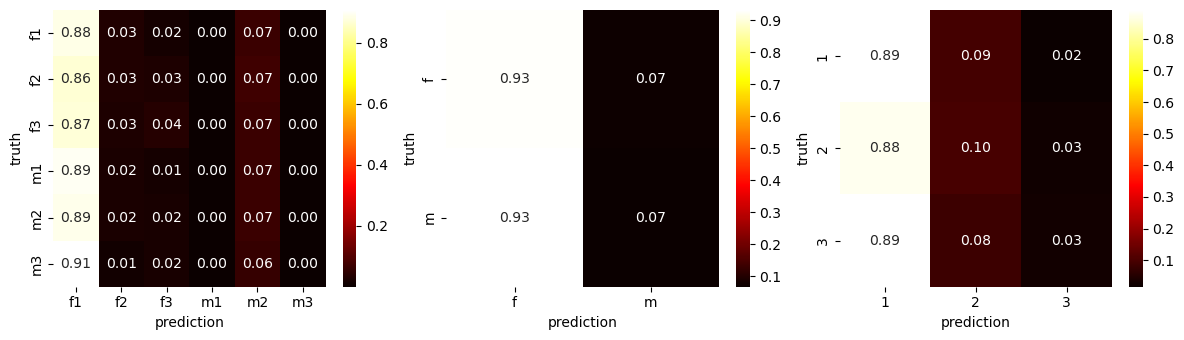

correct classification rate:          0.1754 (random guessing: 0.1667)
correct classification rate (gender): 0.4933 (random guessing: 0.5000)
correct classification rate (age):    0.3569 (random guessing: 0.3333)


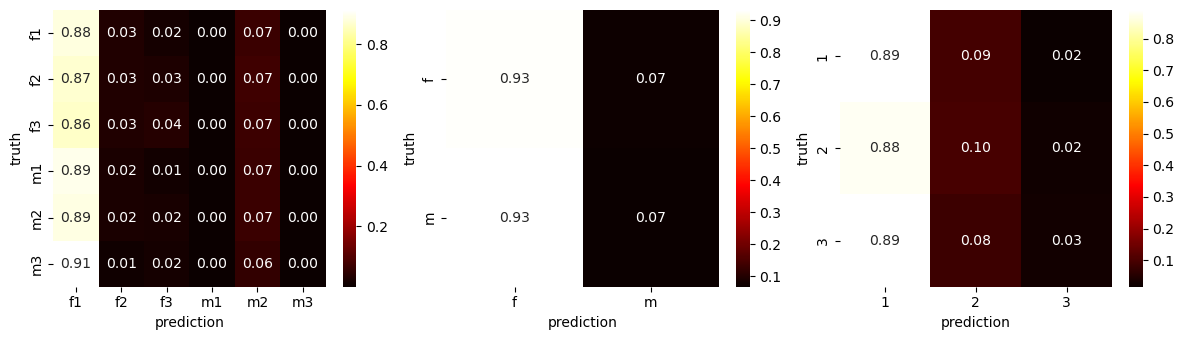

In [51]:
show_accuracy(y_train, y_train_pred)
show_accuracy(y_test, y_test_pred)

Again minimization did not converge in acceptable time and predictions are not satisfying.

Scikit-Learn provides a technique known as *kernel approximation*. The idea is to mimic the behavior of a kernel by an inner product in a relatively low dimensional space. Using kernel approximation we should get similar results like from a kernel SVM, but from a linear SVM on a low dimensional space. See [Random Features for Large-Scale Kernel Machines](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf), especially Section 1, for some more background.

In [52]:
import sklearn.kernel_approximation as kernel_approximation

Kernel approximation requires very much memory. Avoid parallelization (parameter `n_jobs`) to save memory. The values for $\alpha$ and $\gamma$ below were obtained via hyperparameter optimization (took several days).

In [53]:
# cell execution takes several minutes and requires 70 GB of memory

rbf = kernel_approximation.RBFSampler(n_components=10000, gamma=0.13)
X_train_rbf = rbf.fit_transform(X_train)
X_test_rbf = rbf.transform(X_test)

rbfsvm = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=0.00390625,
                                    verbose=1, n_jobs=-1, tol=1e-3, max_iter=100)
rbfsvm.fit(X_train_rbf, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


-- Epoch 1-- Epoch 1

-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 0.09, NNZs: 10000, Bias: -1.005309, T: 522187, Avg. loss: 0.174627
Total training time: 11.02 seconds.
-- Epoch 2
Norm: 0.07, NNZs: 10000, Bias: -1.004696, T: 522187, Avg. loss: 0.193802
Total training time: 11.12 seconds.
-- Epoch 2
Norm: 0.19, NNZs: 10000, Bias: -1.005802, T: 522187, Avg. loss: 0.338775
Total training time: 12.17 seconds.
-- Epoch 2
Norm: 0.12, NNZs: 10000, Bias: -1.002819, T: 522187, Avg. loss: 0.354316
Total training time: 12.33 seconds.
-- Epoch 2
Norm: 0.12, NNZs: 10000, Bias: -1.000431, T: 522187, Avg. loss: 0.469682
Total training time: 13.28 seconds.
-- Epoch 2
Norm: 0.12, NNZs: 10000, Bias: -1.002134, T: 522187, Avg. loss: 0.476062
Total training time: 13.32 seconds.
-- Epoch 2
Norm: 0.07, NNZs: 10000, Bias: -1.002831, T: 1044374, Avg. loss: 0.174006
Total training time: 23.26 seconds.
-- Epoch 3
Norm: 0.05, NNZs: 10000, Bias: -1.002826, T: 1044374, Avg. loss: 0.193173
Total training time

[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:  1.3min remaining:  2.7min


Norm: 0.10, NNZs: 10000, Bias: -1.002764, T: 3655309, Avg. loss: 0.337700
Total training time: 93.07 seconds.
Convergence after 7 epochs took 93.07 seconds
Norm: 0.05, NNZs: 10000, Bias: -0.999862, T: 3133122, Avg. loss: 0.467934
Total training time: 93.08 seconds.
-- Epoch 7
Norm: 0.05, NNZs: 10000, Bias: -1.000170, T: 3133122, Avg. loss: 0.474347
Total training time: 93.70 seconds.
-- Epoch 7
Norm: 0.05, NNZs: 10000, Bias: -1.000561, T: 3655309, Avg. loss: 0.353033
Total training time: 93.97 seconds.
Convergence after 7 epochs took 93.97 seconds
Norm: 0.05, NNZs: 10000, Bias: -1.000004, T: 3655309, Avg. loss: 0.467928
Total training time: 107.42 seconds.
Convergence after 7 epochs took 107.42 seconds
Norm: 0.04, NNZs: 10000, Bias: -1.000248, T: 3655309, Avg. loss: 0.474341
Total training time: 108.28 seconds.
Convergence after 7 epochs took 108.28 seconds


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.8min finished


SGDClassifier(alpha=0.00390625, max_iter=100, n_jobs=-1, verbose=1)

In [54]:
y_train_pred = rbfsvm.predict(X_train_rbf)
y_test_pred = rbfsvm.predict(X_test_rbf)

correct classification rate:          0.4220 (random guessing: 0.1667)
correct classification rate (gender): 0.6626 (random guessing: 0.5000)
correct classification rate (age):    0.5989 (random guessing: 0.3333)


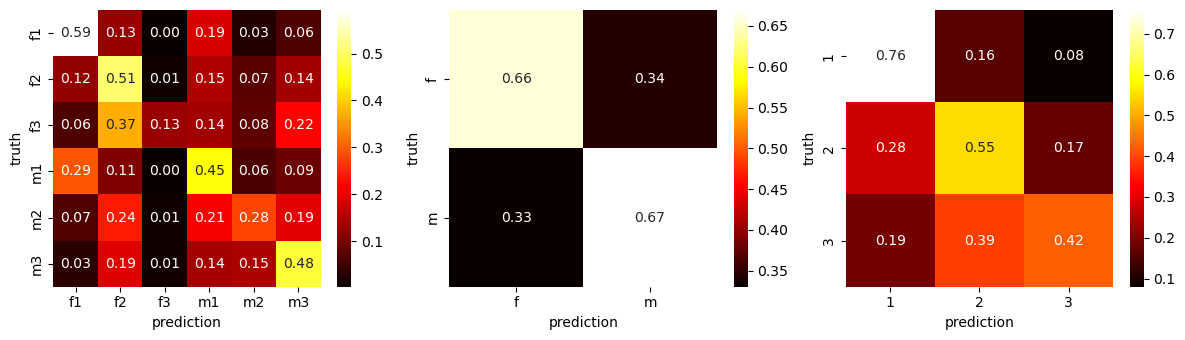

correct classification rate:          0.3964 (random guessing: 0.1667)
correct classification rate (gender): 0.6465 (random guessing: 0.5000)
correct classification rate (age):    0.5807 (random guessing: 0.3333)


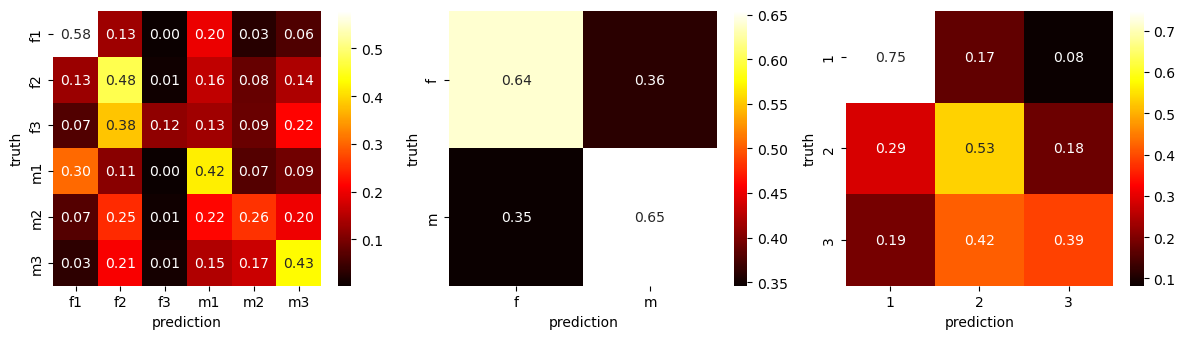

In [55]:
show_accuracy(y_train, y_train_pred)
show_accuracy(y_test, y_test_pred)

Prediction quality on training set:

```
correct classification rate:          0.4348 (random guessing: 0.1667)
correct classification rate (gender): 0.6607 (random guessing: 0.5000)
correct classification rate (age):    0.6243 (random guessing: 0.3333)
```

Prediction quality on test set:

```
correct classification rate:          0.4105 (random guessing: 0.1667)
correct classification rate (gender): 0.6466 (random guessing: 0.5000)
correct classification rate (age):    0.6095 (random guessing: 0.3333)
```

We see that prediction quality is not as good as for fast and simple naive Bayes classification or linear SVC.
A reason might be lack of data. Although we have more than 500000 training samples the data set is very sparse in a 37000 dimensional space. If we wanted to have at least one sample per vertex of a 37000 dimensional cube, we would require $2^{37000}=(2^{37})^{1000}>(10^{11})^{1000}=10^{11000}$ samples. It's very likely that our classes can be seprated by hyperplanes without need for nonlinear separation.

## Decision Tree

Due to their simplicity decision trees are well suited for large scale classification problems, too. As we will see below, prediction quality is not as good as with naive Bayes. But for sake of completeness we provide some variants here.

### Simple Decision Tree

Scikit-Learn's [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) by default yields a fully grown tree. With more than 37000 features and more than 500000 samples the tree would be too large to fit into memory. Thus, we cannot use pruning, but have to limit the tree's size in advance.

In [56]:
import sklearn.tree as tree

In [57]:
dtc = tree.DecisionTreeClassifier(max_depth=10)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [58]:
y_train_pred = dtc.predict(X_train)
y_test_pred = dtc.predict(X_test)

correct classification rate:          0.3101 (random guessing: 0.1667)
correct classification rate (gender): 0.5736 (random guessing: 0.5000)
correct classification rate (age):    0.5356 (random guessing: 0.3333)


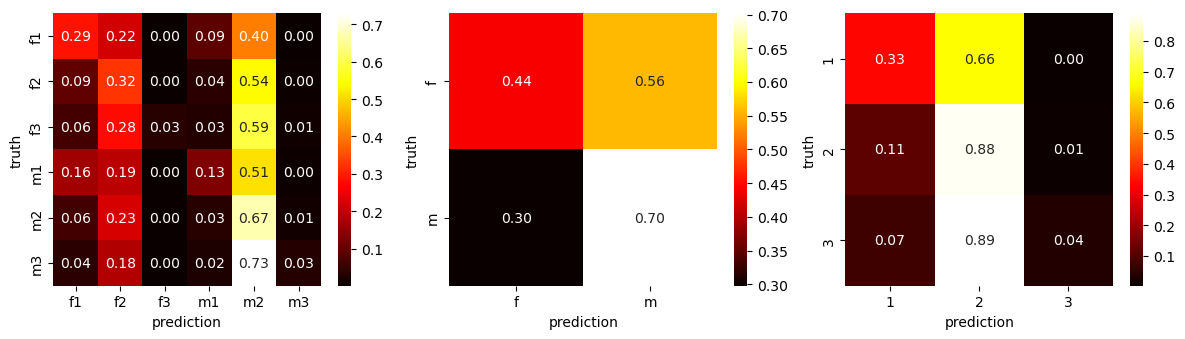

correct classification rate:          0.3013 (random guessing: 0.1667)
correct classification rate (gender): 0.5691 (random guessing: 0.5000)
correct classification rate (age):    0.5300 (random guessing: 0.3333)


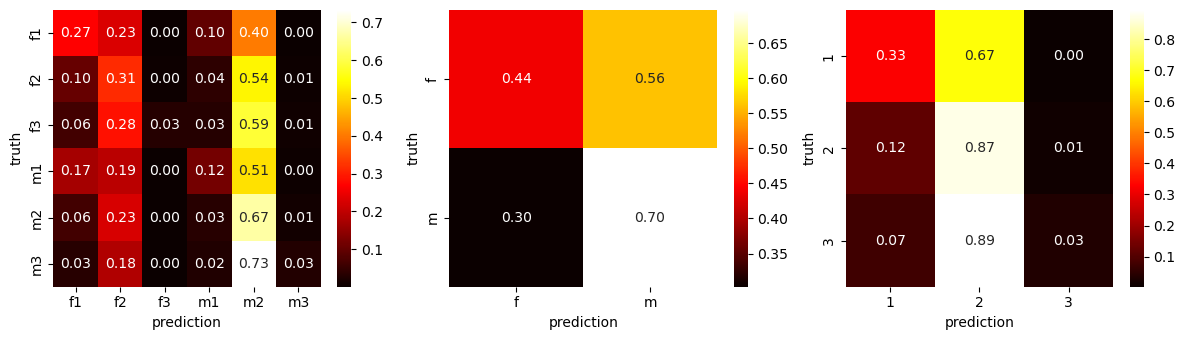

In [59]:
show_accuracy(y_train, y_train_pred)
show_accuracy(y_test, y_test_pred)

### Random Forest

Applying bagging to decision trees is known as random forests. Scikit-Learn's [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) trains a number of decision trees and then calculates average class probabilites. The class with the highest averaged probability is used as prediction. Again we have to limit the size of the trees.

In [60]:
import sklearn.ensemble as ensemble

In [61]:
rf = ensemble.RandomForestClassifier(n_estimators=100, max_depth=10)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10)

correct classification rate:          0.3101 (random guessing: 0.1667)
correct classification rate (gender): 0.5736 (random guessing: 0.5000)
correct classification rate (age):    0.5356 (random guessing: 0.3333)


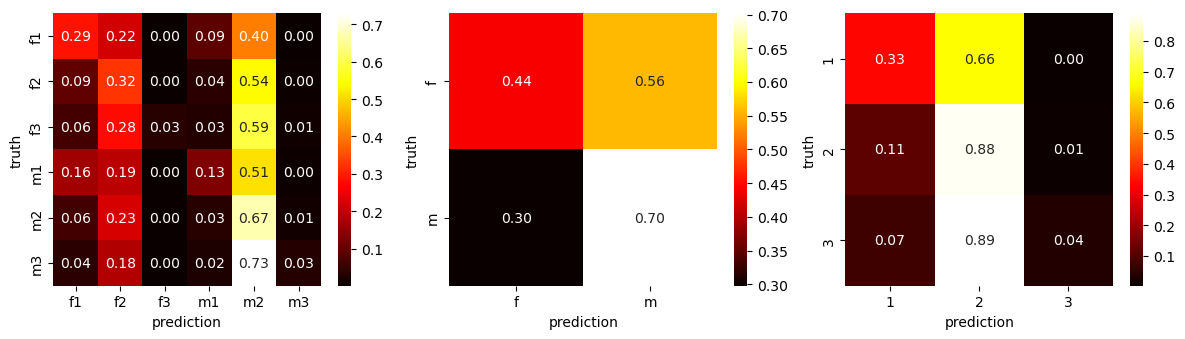

correct classification rate:          0.3013 (random guessing: 0.1667)
correct classification rate (gender): 0.5691 (random guessing: 0.5000)
correct classification rate (age):    0.5300 (random guessing: 0.3333)


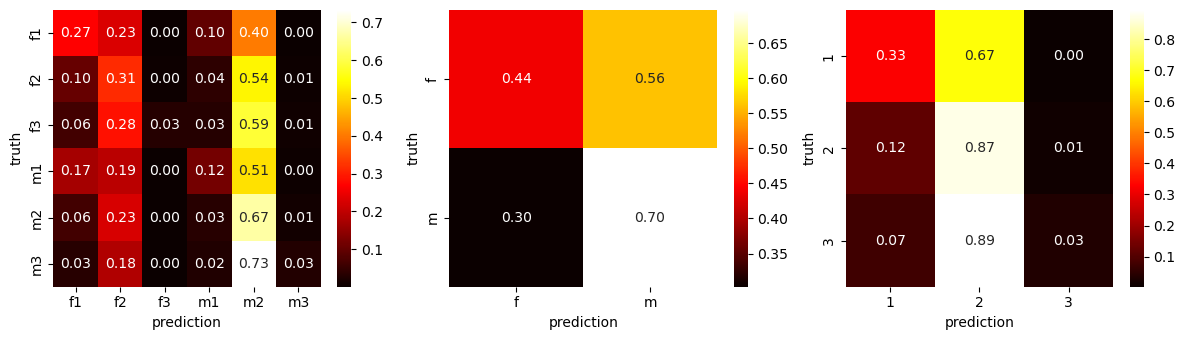

In [62]:
show_accuracy(y_train, y_train_pred)
show_accuracy(y_test, y_test_pred)

### Boosted Trees

We may use AdaBoost in conjuction with decision stumps (trees with depth 1). This is the default behavior of Scikit-Learn's [`AdaBoostClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html).

In [63]:
ada = ensemble.AdaBoostClassifier(n_estimators=100)
ada.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [64]:
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

correct classification rate:          0.3560 (random guessing: 0.1667)
correct classification rate (gender): 0.6050 (random guessing: 0.5000)
correct classification rate (age):    0.5800 (random guessing: 0.3333)


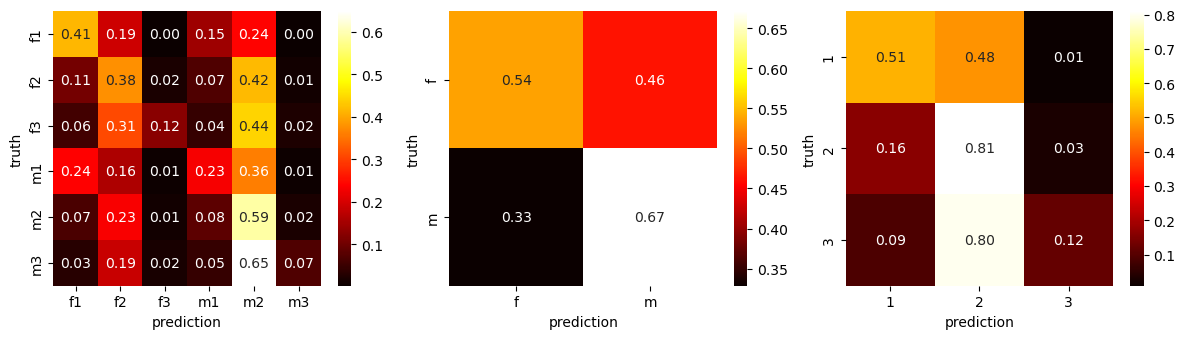

correct classification rate:          0.3540 (random guessing: 0.1667)
correct classification rate (gender): 0.6020 (random guessing: 0.5000)
correct classification rate (age):    0.5805 (random guessing: 0.3333)


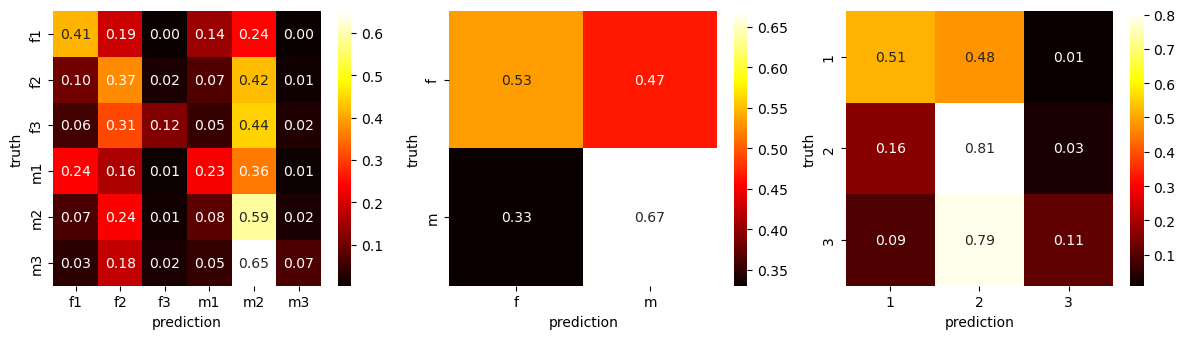

In [65]:
show_accuracy(y_train, y_train_pred)
show_accuracy(y_test, y_test_pred)